<h1 style="font-size: 40px; text-align:center;">VIC: Introduction to Visual Computing - 2022-23 </h1>

# Summary

0. [Project Outline](#Project-Outline)
1. [Libraries](#Libraries)
2. [Dataset](#Dataset)
3. [Video Building](#Video-Building)
4. [Data Preprocessing](#Data-Preprocessing)


## Project Outline



**Instructor:** Maria Vakalopoulou </br>
**T.A.:** Joseph Boyd </br>
**Due Date:** March 15, 2023 </br>

This is VIC Assignment 2. This time you are to implement a system that outputs object detection bounding boxes of cars in a dashcam videos. You are expected to submit your prediction to a Kaggle challenge at the following link, where you will also find the dataset and further instructions:

https://www.kaggle.com/t/d4ce01f69c874429b9f467595a2b3f8c

You have a set of frames available for training in the `train/` directory, and their bounding boxes in `train.csv`, having format:

```x, y, width, height```

Your task is to produce bounding boxes for each frame in the `test/` directory.  **N.B.** Because of limitations of in-class Kaggle, your final submission file will be of a slightly different format to `train.csv`.

### Evaluation

Submissions are evaluated with respect to the Sørensen–Dice coefficient,

$$DSC = \frac{2|X \cap Y|}{|X| + |Y|},$$

the intersection of the prediction X and the ground truth solution Y over the sum of their parts. The minimum is 0 (no intersection), and the maximum is 1 (perfect overlap). The mean DSC over all test images is your final score. **N.B.** that although the challenge is posed as an object detection problem, it is evaluated as a segmentation problem i.e. X and Y will be binary masks (see below). This is due to some limitations of Kaggle as used in-class mode.

An unspecified 50% split of the test data contributes to a "public leaderboard", with the remaining data contributing to a "private leaderboard", which is not visible until the end of the competition. This is to prevent overfitting to the test data.

### Submitting to Kaggle

Submissions to the Kaggle challenge can be made in the form of a .csv file (see `sample_submission.csv`), consisting of two columns with one row per image:
```
Id,Predicted
test/001.jpg,192425 100 193705 100 ...
test/002.jpg,192425 100 193705 100 ...
test/003.jpg,192425 100 193705 100 ...
...
```
`Id` - the image id, which is the path to the image from the project root--must be exact.

`Predicted` - The [run length encoding](https://en.wikipedia.org/wiki/Run-length_encoding) of the binary mask resulting from your concatenated bounding boxes. It is recommended to use the supplied function `run_length_encoding` to automate this. An example is given in the `Assignment2.ipynb` notebook. **N.B.** If you change the size of the images during your pipeline, be sure to resize your final bounding boxes to  (1280x720).

### Grading

Your work will be evaluated according to the following:

- Solution design (40%): algorithmic complexity, technical innovation, performance (as evaluated on Kaggle). Simple ideas can achieve full marks if they are well-argued and perform well.

- Implementation (40%): code quality, efficiency, clarity of documentation (code should be well commented). You should submit all code required to train/test your pipeline in a `.ipynb` notebook or a set of `.py` file(s).

- Report (~1 page) (20%): Description of pipeline and justification of design choices, results and failure cases. In general, we want to know why you did one thing and not another.

**PLUS** the best 5 leaderboard submissions will receive +1 for the grade of the assignment.

**N.B.** This is an individual assignment. All students are expected to make at least one Kaggle submission and submit their own project code and report.

You should send your assignment by email to maria.vakalopoulou@centralesupelec.fr, the name of the subject of the email should be: VIC\_Assignment2\_name.

### FAQ

**Q:** Can I use external datasets?</br>
**A:** Yes.

**Q:** Must I code algorithms from scratch?</br>
**A:** You will be graded on the design/implementation of your solution pipeline, which ordinarily will comprise multiple algorithms (e.g. filters, features, machine learning). Unlike the labs and previous assignment, you are not required to code these individual algorithms from scratch.

**Q:** Can my pipeline take a long time to run?</br>
**A:** It is acceptable if your training and/or testing takes some hours to run. However, in this case you should argue convincingly in your report that this is fully warranted.

**Q:** Can I use deep learning?</br>
**A:** You are quite free in the design of your solution pipeline. However, **NO DEEP LEARNING APPROACHES ARE ALLOWED**. You should use classic methods to complete this assignment!

# Libraries

In [1]:
#Standard library imports
import os
import pickle
import glob
import random
import json
from collections import deque

# Third party imports
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets
from tqdm import tqdm
from pprint import pprint

# Local imports
from src.utils.annotate import draw_annotation, show_annotation
from src.utils.load_data import load_train_csv, get_images
from src.utils.extract_features import extract_features, save_features
from src.utils.bbox_to_mask import bounding_boxes_to_mask, run_length_encoding

from src.classes.color_extractor import ColorFeaturesExtractor
from src.classes.hog_extractor import HoGFeaturesExtractor
from src.classes.spatial_extractor import SpatialFeaturesExtractor
from src.classes.vehicle_detector import VehicleDetector
from src.classes.vehicle_classifier import VehicleClassifier
from src.classes.frame_memory import FrameMemory

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

# Params

In order to make it easier to ***fine-tune*** the hyperparameters of the model, I created a `params.json` file that I can use to store all the parameters of the model.   
This way, I can easily change the parameters and run the model again without having to change the code.

In [2]:
# Open JSON paramerters file
with open('./config/params.json') as f:
    params = json.load(f)
pprint(params)

{'classifier': 'LinearSVC',
 'color_features_settings': {'color_histogram_bins': 32,
                             'color_histogram_range': [0, 256],
                             'extract_color_features': True},
 'color_space': 'RGB',
 'file_names': {'datasets': 'train_test_datasets',
                'non_vehicle_features': 'non_vehicle_features',
                'vehicle_features': 'vehicle_features'},
 'heatmap': {'heat_queue_length': 1, 'heatmap_threshold': 0.45},
 'hog_features_settings': {'cells_per_block': [2, 2],
                           'extract_hog_features': True,
                           'hog_channel_to_extract': 'all',
                           'hog_orientations': 9,
                           'pixels_per_cell': [7, 7]},
 'paths': {'path_to_csv': './data/initial/train.csv',
           'path_to_frames': './data/initial/raw/frames/',
           'path_to_models': './models/',
           'path_to_videos': './data/initial/raw/videos/'},
 'predict_proba': True,
 'sliding_wind

In [3]:
# Parameters variables
COLOR_SPACE = params['color_space']

# Spatial binning parameters
EXTRACT_SPATIAL_FEATURES = params['spatial_features_settings']['extract_spatial_features']
SPATIAL_SIZE = tuple(params['spatial_features_settings']['spatial_size'])

# Color histogram parameters
EXTRACT_COLOR_FEATURES = params['color_features_settings']['extract_color_features']
COLOR_HISTOGRAM_BINS = params['color_features_settings']['color_histogram_bins']
COLOR_HISTOGRAM_RANGE = tuple(params['color_features_settings']['color_histogram_range'])

# HoG parameters
EXTRACT_HOG_FEATURES = params['hog_features_settings']['extract_hog_features']
HOG_ORIENTATIONS = params['hog_features_settings']['hog_orientations']
PIXELS_PER_CELL = tuple(params['hog_features_settings']['pixels_per_cell'])
CELLS_PER_BLOCK = tuple(params['hog_features_settings']['cells_per_block'])
HOG_CHANNEL_TO_EXTRACT = params['hog_features_settings']['hog_channel_to_extract']

PATH_TO_CSV = params["paths"]["path_to_csv"]
PATH_TO_FRAMES = params["paths"]["path_to_frames"]
PATH_TO_VIDEOS = params["paths"]["path_to_videos"]

# Model params variables
TEST_SIZE = params['test_size']
CLASSIFIER = params['classifier'] # "LinearSVC", "SVC", "RandomForestClassifier", "AdaBoost", "XGBoost", "GradientBoosting","PCA"
FILENAME_datasets = params['file_names']['datasets']
FILENAME_vehicle_features = params['file_names']['vehicle_features']
FILENAME_non_vehicle_features = params['file_names']['non_vehicle_features']
PATH_TO_MODELS  = params["paths"]['path_to_models']

# Data Preprocessing

- Load the dataset as `.csv` file

In [16]:
df_ground_truth, no_bbox_counter = load_train_csv(path_to_csv=PATH_TO_CSV,path_to_frames=PATH_TO_FRAMES)
print(f"Number of frames without bounding boxes: {no_bbox_counter}")
df_ground_truth.head()

Number of frames without bounding boxes: 364


frame_id  \
0  ./data/initial/raw/frames/train/A_001.jpg   
1  ./data/initial/raw/frames/train/A_002.jpg   
2  ./data/initial/raw/frames/train/A_003.jpg   
3  ./data/initial/raw/frames/train/A_004.jpg   
4  ./data/initial/raw/frames/train/A_005.jpg   

                                      bounding_boxes  
0  [[0.0, 225.0, 214.0, 317.0], [0.0, 172.0, 345....  
1  [[0.0, 254.0, 190.0, 293.0], [0.0, 169.0, 338....  
2  [[0.0, 306.0, 59.0, 241.0], [0.0, 155.0, 306.0...  
3  [[0.0, 143.0, 239.0, 298.0], [164.0, 223.0, 24...  
4  [[0.0, 217.0, 137.0, 270.0], [55.0, 209.0, 323...

- Define `Height` and `Width` of the images

In [17]:
H, W = 720, 1280
N = len(df_ground_truth)

- Display each annotated frame with the bounding box

In [18]:
def f_display(frame_id):
    show_annotation(df_ground_truth, frame_id)

interact(f_display, frame_id=widgets.IntSlider(min=0, max=N-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='frame_id', max=2221), Output()), _dom_classes=('widget-i…

<function __main__.f_display(frame_id)>

- Allows to extract, from the bounding box coordinates, the image of the vehicle at the desired `resolution`.   
!RUN THIS CELL ONLY IF YOU WANT TO SAVE THE IMAGES OF THE VEHICLES IN EACH FRAME!

In [7]:
#extract_vehicle_images_from_bboxs(csv_df=df_ground_truth, resolution= (64, 64))

- Get the `vehicle` and `non_vehicle` images from the different datasets

In [8]:
# Pathways to the images
INITIAL_VEHICLES = './data/initial/vehicles/**/*.png'
INITIAL_NON_VEHICLES = './data/initial/non-vehicles/**/*.png'
UDACITY_VEHICLES = './data/udacity/vehicles/**/*.png'
UDACITY_NON_VEHICLES = './data/udacity/non-vehicles/**/*.png'

# Use glob to get the list of imgs
vehicle_imgs = get_images(UDACITY_VEHICLES) #+ get_images(INITIAL_VEHICLES)
non_vehicle_imgs = get_images(INITIAL_NON_VEHICLES) + get_images(UDACITY_NON_VEHICLES)

Number of vehicle images: 8792
Image size: (64, 64, 3)
Nb of channels: 3
Number of non-vehicle images: 8968
Image size: (64, 64, 3)
Nb of channels: 3


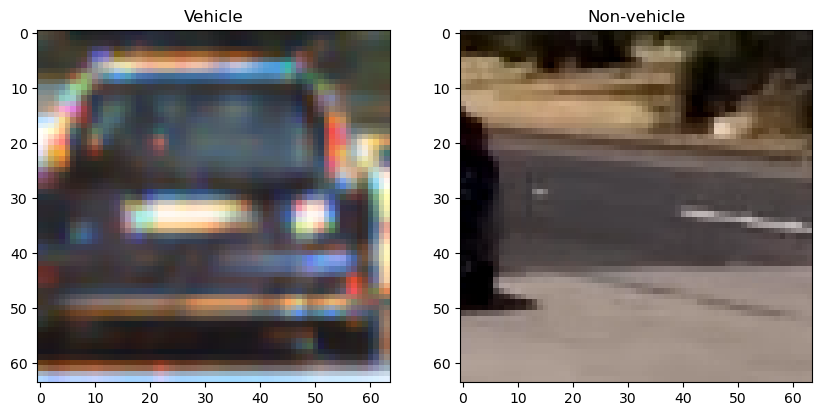

In [9]:
# Display information about the dataset
print("="*50)
print(f"Number of vehicle images: {len(vehicle_imgs)}")
print(f"Image size: {vehicle_imgs[0].shape}")
print(f"Nb of channels: {vehicle_imgs[0].shape[2]}")
print("="*50)
print(f"Number of non-vehicle images: {len(non_vehicle_imgs)}")
print(f"Image size: {non_vehicle_imgs[0].shape}")
print(f"Nb of channels: {non_vehicle_imgs[0].shape[2]}")

# Display a random vehicle image
_vehicleimg = random.choice(vehicle_imgs)
_nonvehicleimg = random.choice(non_vehicle_imgs)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Vehicle")
axes[0].imshow(_vehicleimg)
axes[1].set_title("Non-vehicle")
axes[1].imshow(_nonvehicleimg)

# Video Building

Allows to build a video from a set of images. Made this function to be able to better vizualize the differents videos & **get an idea of the _data disparity_**.

### Test Raw Video

In [10]:
frameSize = (1280,720)

out = cv2.VideoWriter(PATH_TO_VIDEOS + 'test_raw.mp4',cv2.VideoWriter_fourcc(*'avc1'), 9, frameSize)

#for filename in glob.glob('./test/*.jpg'):
# Loop through the image frames in the dataset
for i in tqdm(range(1, len(os.listdir('./data/initial/raw/frames/test')))):
    # Check if the frame exists
    if os.path.exists(f'./data/initial/raw/frames/test/{i:0>3}.jpg'):
        # Read the image frame
        frame = cv2.imread(f'./data/initial/raw/frames/test/{i:0>3}.jpg')
        out.write(frame)

out.release()

100%|██████████| 201/201 [00:03<00:00, 57.80it/s]


### Train Raw Videos

In [11]:
frameSize = (1280,720)

video_types = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J','K']

for x in video_types:
    out = cv2.VideoWriter(PATH_TO_VIDEOS + f'train_{x}_raw.mp4',cv2.VideoWriter_fourcc(*'avc1'), 9, frameSize)
    for i in tqdm(range(1, len(os.listdir('./data/initial/raw/frames/train')))):
        # Check if the frame exists
        if os.path.exists(f'./data/initial/raw/frames/train/{x}_{i:0>3}.jpg'):
            # Read the image frame
            frame = cv2.imread(f'./data/initial/raw/frames/train/{x}_{i:0>3}.jpg')
            out.write(frame)

out.release()

100%|██████████| 2221/2221 [00:03<00:00, 618.24it/s] 


### Train Annotated Videos

In [12]:
frameSize = (1280,720)

out = cv2.VideoWriter(PATH_TO_VIDEOS + 'train_annotated_full_raw.mp4',cv2.VideoWriter_fourcc(*'avc1'), 9, frameSize)
for i in tqdm(range(0, len(os.listdir('./data/initial/raw/frames/train'))-1)):
    # Read the image frame
    frame = draw_annotation(df_ground_truth, i)
    # Convert BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame)

out.release()

100%|██████████| 2221/2221 [00:55<00:00, 40.32it/s]


# Features Vizualization

_Exploratory Data Analysis:_ extracts features for one specific set of vehicle/non_vehicle images and displays them.   
Allows to get an idea of the features collected for eeach small image.


#### Spatial Bin Features

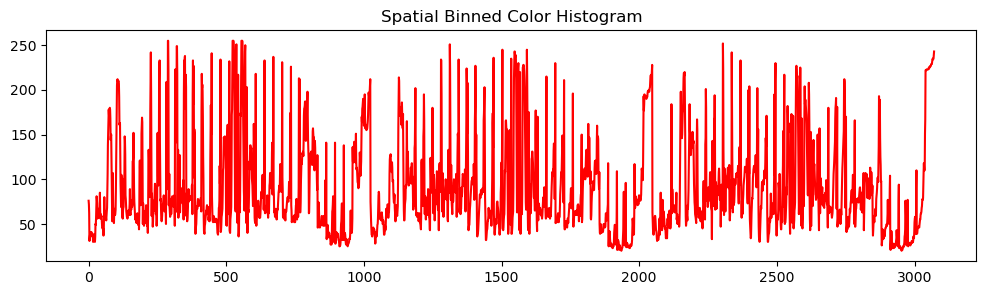

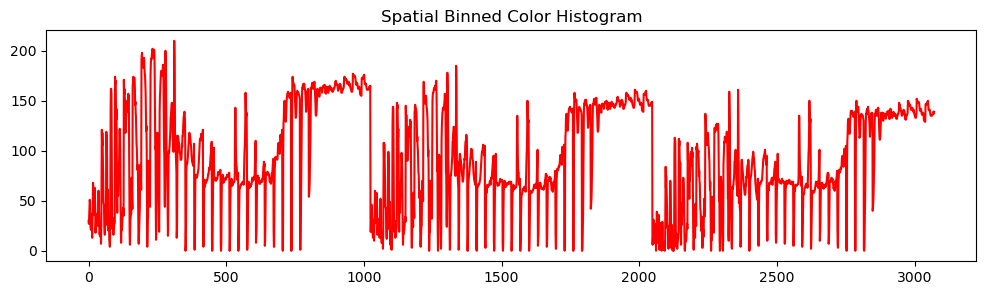

In [10]:
spatial_features_extractor = SpatialFeaturesExtractor(size=SPATIAL_SIZE)
vehicle_spatial_features, vehicle_spatial_hist = spatial_features_extractor.extract(img=_vehicleimg,visualize=True)
non_vehicle_spatial_features, non_vehicle_spatial_hist = spatial_features_extractor.extract(img=_nonvehicleimg,visualize=True)

#### Color Histogram Features

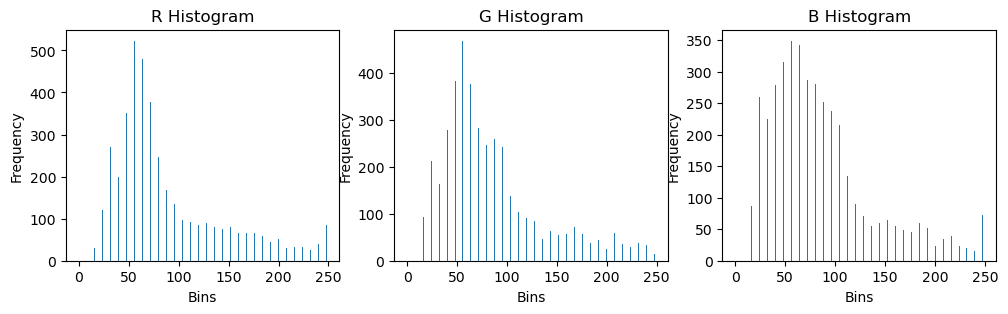

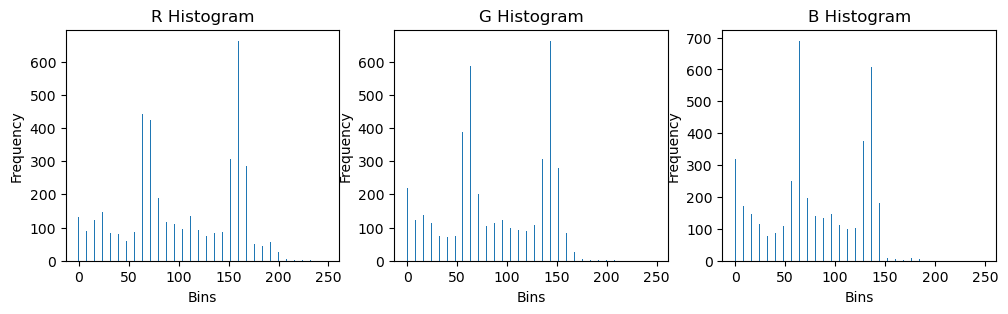

In [11]:
color_hist_features_extractor = ColorFeaturesExtractor(n_bins = COLOR_HISTOGRAM_BINS, histogram_range = COLOR_HISTOGRAM_RANGE)
vehicle_color_hist_features, vehicle_color_hist = color_hist_features_extractor.extract(img=_vehicleimg,visualize=True)
non_vehicle_color_hist_features, non_vehicle_color_hist = color_hist_features_extractor.extract(img=_nonvehicleimg,visualize=True)

#### Histogram of Oriented Gradients Features

HoG settings:
Pixels per cell:  (7, 7)
Cells per block:  (2, 2)
Orientations:  9


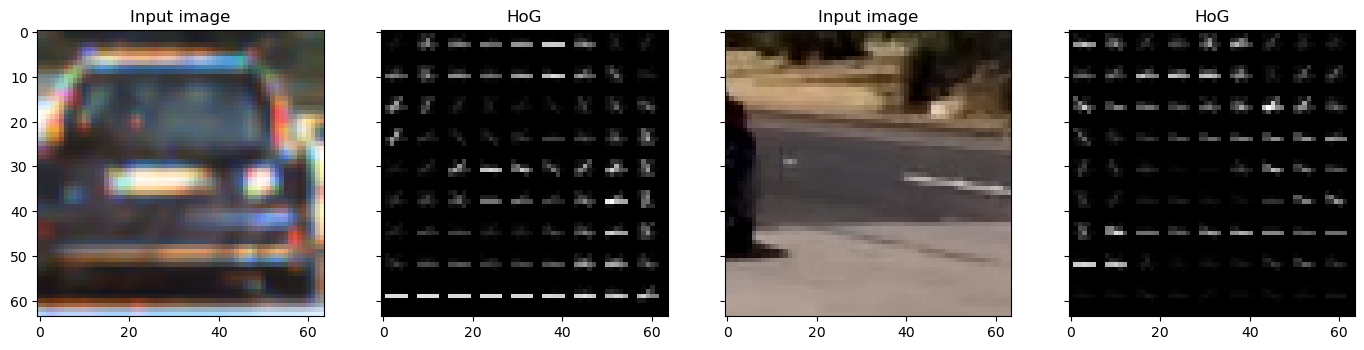

In [12]:
hog_features_extractor = HoGFeaturesExtractor(orientations=HOG_ORIENTATIONS, pixels_per_cell=PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK, channel_to_extract=HOG_CHANNEL_TO_EXTRACT)
vehicle_hog_features, vehicle_hog_image = hog_features_extractor.extract(img=_vehicleimg,visualize=True)
non_vehicle_hog_features, non_vehicle_hog_image = hog_features_extractor.extract(img=_nonvehicleimg,visualize=True)

print("="*50)
print("HoG settings:")
print("Pixels per cell: ", PIXELS_PER_CELL)
print("Cells per block: ", CELLS_PER_BLOCK)
print("Orientations: ", HOG_ORIENTATIONS)
print("="*50)

fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(17, 12), sharex=True, sharey=True)

ax1.imshow(_vehicleimg, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.imshow(vehicle_hog_image, cmap=plt.cm.gray)
ax2.set_title('HoG')

ax3.imshow(_nonvehicleimg, cmap=plt.cm.gray)
ax3.set_title('Input image')

ax4.imshow(non_vehicle_hog_image, cmap=plt.cm.gray)
ax4.set_title('HoG')

plt.show()


# Features Extraction

- Extract the features from the images

In [13]:
vehicles_features = extract_features(path=vehicle_imgs, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE, color_histogram_bins= COLOR_HISTOGRAM_BINS, hog_orientations = HOG_ORIENTATIONS, pixels_per_cell = PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK, hog_channel_to_extract = HOG_CHANNEL_TO_EXTRACT, extract_spatial_features=EXTRACT_SPATIAL_FEATURES, extract_color_features=EXTRACT_COLOR_FEATURES, extract_hog_features=EXTRACT_HOG_FEATURES, color_histogram_range=COLOR_HISTOGRAM_RANGE)
non_vehicles_features = extract_features(path=non_vehicle_imgs, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE, color_histogram_bins= COLOR_HISTOGRAM_BINS, hog_orientations = HOG_ORIENTATIONS, pixels_per_cell = PIXELS_PER_CELL, cells_per_block=CELLS_PER_BLOCK, hog_channel_to_extract = HOG_CHANNEL_TO_EXTRACT, extract_spatial_features=EXTRACT_SPATIAL_FEATURES, extract_color_features=EXTRACT_COLOR_FEATURES, extract_hog_features=EXTRACT_HOG_FEATURES, color_histogram_range=COLOR_HISTOGRAM_RANGE)

100%|██████████| 8968/8968 [01:23<00:00, 107.27it/s]


In [14]:
print("="*50)
print("Type of vehicle_features variable: ", type(vehicles_features))
print("Shape of vehicle_features variable: ", np.shape(vehicles_features))
print("="*50)
print("Type of non_vehicle_features variable: ", type(non_vehicles_features))
print("Shape of non_vehicle_features variable: ", np.shape(non_vehicles_features))

Type of vehicle_features variable:  <class 'list'>
Shape of vehicle_features variable:  (8792, 10080)
Type of non_vehicle_features variable:  <class 'list'>
Shape of non_vehicle_features variable:  (8968, 10080)


- Save features in a `.pkl` file (in order to avoid re-extracting the features each time)

In [15]:
save_features(path='./models/', file_name=params['file_names']['vehicle_features'], features=vehicles_features)
save_features(path='./models/', file_name=params['file_names']['non_vehicle_features'], features=non_vehicles_features)

Saving features to pickle file ./models/vehicle_features.pkl...
Features cached in pickle file.
Saving features to pickle file ./models/non_vehicle_features.pkl...
Features cached in pickle file.


# Vehicle Classifier

- Reload `.pkl` files containing the features

In [16]:
#### VEHICLES

# Load file
file = open(PATH_TO_MODELS + FILENAME_vehicle_features + '.pkl', 'rb')
vehicle_data = pickle.load(file)
file.close()

# Retrieve features by loading pickle files
vehicles_features = vehicle_data['features']

#### NON VEHICLES

# Load file
file = open(PATH_TO_MODELS + FILENAME_non_vehicle_features + '.pkl', 'rb')
non_vehicle_data = pickle.load(file)
file.close()

# Retrieve features by loading pickle files
non_vehicles_features = non_vehicle_data['features']

- Build train and test datasets (with defined `random_state`) to train our classifier. This classifier will be used to detect the vehicles in the small windows input to it, thanks to the features extracted.

In [17]:
vehicle_classifier = VehicleClassifier(vehicle_features=vehicles_features,non_vehicle_features=non_vehicles_features)
X_train, X_test, y_train, y_test, scaler = vehicle_classifier.build_train_test_sets(test_size=TEST_SIZE, random_state=42)
print("="*20 +  "Train set" + "="*20)
print("="*50)
print("Shape of X_train variable: ", np.shape(X_train))
print("Shape of y_train variable: ", np.shape(y_train))
print("-"*50)
print("Number of cars in train set: ", np.sum(y_train == 1))
print("Number of non-cars in train set: ", np.sum(y_train == 0))
print("="*20 +  "Test set" + "="*20)
print("="*50)
print("Shape of X_test variable: ", np.shape(X_test))
print("Shape of y_test variable: ", np.shape(y_test))
print("-"*50)
print("Number of cars in test set: ", np.sum(y_test == 1))
print("Number of non-cars in test set: ", np.sum(y_test == 0))

====================Train set====================
Shape of X_train variable:  (13320, 10080)
Shape of y_train variable:  (13320,)
--------------------------------------------------
Number of cars in train set:  6594
Number of non-cars in train set:  6726
====================Test set====================
Shape of X_test variable:  (4440, 10080)
Shape of y_test variable:  (4440,)
--------------------------------------------------
Number of cars in test set:  2198
Number of non-cars in test set:  2242


- Save datasets for further reuse

In [18]:
vehicle_classifier.save_datasets(path='./models/',file_name=FILENAME_datasets)

Saving data to pickle file ./models/train_test_datasets.pkl...
Data cached in pickle file.


 - Train the classifier (i.e. can be a SVM, a Random Forest, etc. -> parametrized in the `params.json` file)

_Note_: I tried to use a `GridSearchCV` to find the best parameters for the classifier, but it was taking too much time to run. What I did instead was to run the model with different parameters and choose the one that gave the best results.

_Note 2_: It was important to use `dual=False` for the `LinearSVC` classifier depending on the number of samples and features; ie. if `n_samples > n_features`, set `dual=False` to avoid the `LinearSVC` to crash.

In [19]:
clf = vehicle_classifier.train(clf=CLASSIFIER, path_to_save=PATH_TO_MODELS)

==============================TRAINING==============================
Training LinearSVC...
Feature vector length: 10080
17.32 seconds to train LinearSVC...
==============================METRICS==============================
Training Accuracy of LinearSVC =  1.0
Test Accuracy of LinearSVC =  0.9865
==============================Saving model...==============================
Model saved in ./models/LinearSVC.pkl


# Vehicle Detector

- Reload model and scaler (fitted on our dataset)

In [4]:
# Load classifier and parameters
with open(PATH_TO_MODELS + CLASSIFIER + '.pkl', mode='rb') as f:
    data = pickle.load(f)
    print(f"{CLASSIFIER} classifier loaded!")
    
model = data['model']
scaler = data['scaler']

LinearSVC classifier loaded!


In [5]:
# Instantiate VehicleDetector class
vehicle_detector = VehicleDetector(color_space=COLOR_SPACE,
        spatial_size=SPATIAL_SIZE,
        color_histogram_bins=COLOR_HISTOGRAM_BINS,
        hog_orientations=HOG_ORIENTATIONS,
        pixels_per_cell=PIXELS_PER_CELL,
        cells_per_block=CELLS_PER_BLOCK,
        hog_channel_to_extract=HOG_CHANNEL_TO_EXTRACT,
        extract_spatial_features=EXTRACT_SPATIAL_FEATURES,
        extract_color_features=EXTRACT_COLOR_FEATURES,
        extract_hog_features=EXTRACT_HOG_FEATURES,
        color_histogram_range=COLOR_HISTOGRAM_RANGE)

In [6]:
WINDOW_SEARCH_AREAS = params['sliding_window_settings']['window_search_areas']
WINDOW_SIZES = params['sliding_window_settings']['window_sizes']
WINDOW_OVERLAP = params['sliding_window_settings']['window_overlap']
PREDICT_PROBA = params['predict_proba']

HEAT_QUEUE_LENGTH = params['heatmap']['heat_queue_length']
HEATMAP_THRESHOLD = params['heatmap']['heatmap_threshold']

-  Loop over ONE SPECIFIC IMAGE and apply the pipeline to detect the vehicles.   
Allows to get an idea of the pipeline and the results obtained.

Time to detect: 30.57 seconds


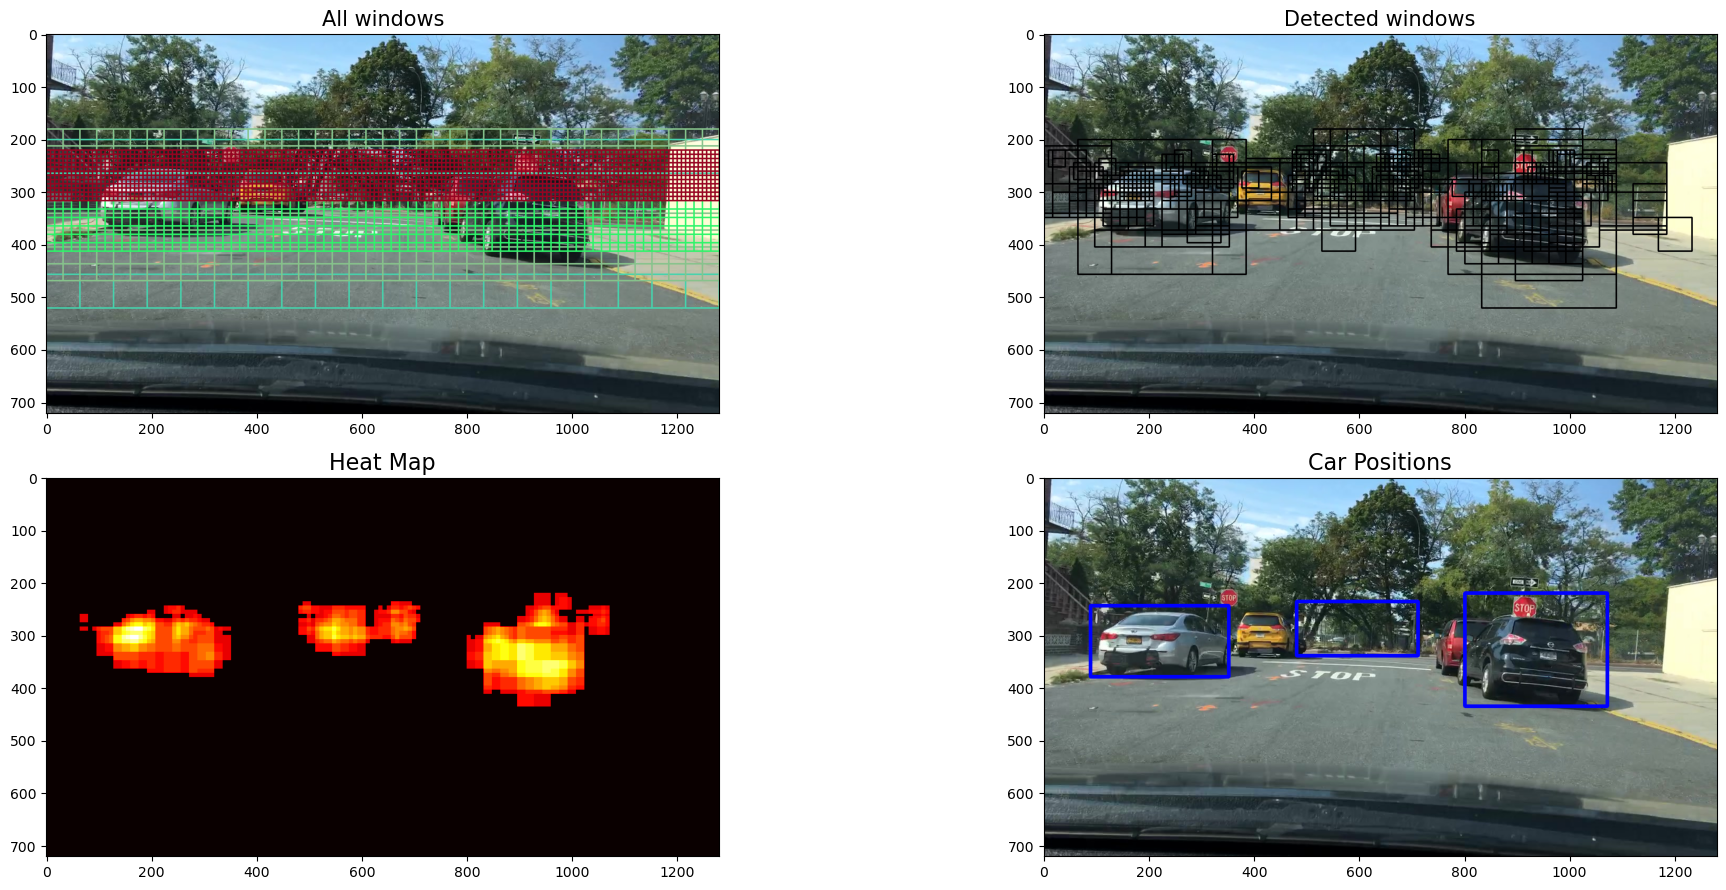

In [11]:
#for img in sorted(glob.glob(PATH_TO_FRAMES + 'test/180.jpg')):
for img in sorted(glob.glob(PATH_TO_FRAMES + 'train/A_199.jpg')):
#for img in sorted(glob.glob('./test1.jpg')):
    
    heat_queue = deque(maxlen=HEAT_QUEUE_LENGTH)
    
    allwindows_img, detected_windows_img, heatmap, draw_img, bounding_boxes, time_to_detect  = vehicle_detector.analyse_frame(frame=img,window_search_areas=WINDOW_SEARCH_AREAS,window_sizes=WINDOW_SIZES,overlap=WINDOW_OVERLAP,clf=model, scaler=scaler,proba=PREDICT_PROBA,heat_queue=heat_queue,threshold=HEATMAP_THRESHOLD)
    
    print(f"Time to detect: {time_to_detect:.2f} seconds")
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
    fig.tight_layout()

    ax1.imshow(allwindows_img)
    ax1.set_title("All windows", fontsize=15)

    ax2.imshow(detected_windows_img)
    ax2.set_title("Detected windows", fontsize=15)

    ax3.imshow(heatmap, cmap="hot")
    ax3.set_title("Heat Map", fontsize=16)

    ax4.imshow(draw_img)
    ax4.set_title("Car Positions", fontsize=16)

    fig.tight_layout()
    
    plt.show()

# Frame Memory

In order to keep in memory the previous detected bounding_boxes, it is possible to smoothen all detected windows at a defined `step_size`, by aggregating all detected windows between frames (n-1)xf+1 to nxf.

Appending new object with centroid: (447, 307)
Appending new object with centroid: (863, 251)
Appending new object with centroid: (1035, 247)
Appending new object with centroid: (1103, 291)
**Found a match**
old centroid= (1103, 291)
new centroid= (1085, 295)
old bbox= [1088  268   31   47]
new bbox= [1070  272 1100  318]
previously detected objects= 0
so far newly detected objects= 4
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 27.55 seconds


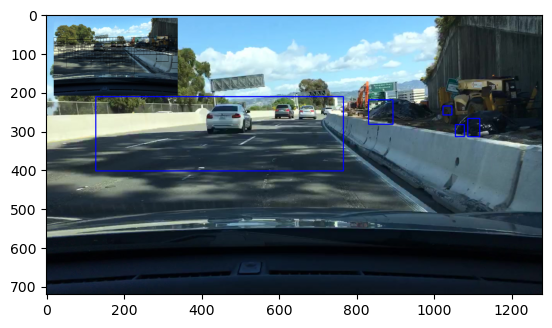

**Found a match**
old centroid= (447, 307)
new centroid= (465, 309)
old bbox= [128 212 639 191]
new bbox= [146 210 784 408]
**Found a match**
old centroid= (863, 251)
new centroid= (865, 255)
old bbox= [832 220  63  63]
new bbox= [834 224 896 286]
previously detected objects= 0
so far newly detected objects= 4
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 27.16 seconds


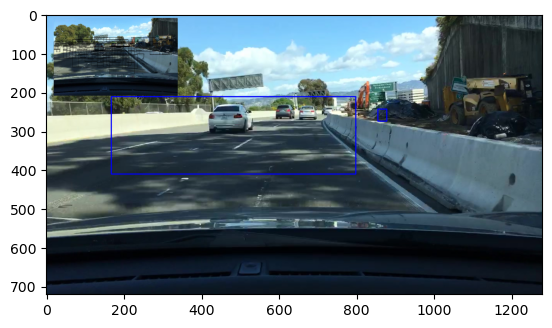

Appending new object with centroid: (579, 315)
Appending new object with centroid: (127, 275)
Appending new object with centroid: (367, 275)
**Found a match**
old centroid= (865, 255)
new centroid= (888, 261)
old bbox= [834 224 896 286]
new bbox= [ 440  118 1336  404]
previously detected objects= 0
so far newly detected objects= 7
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 24.96 seconds


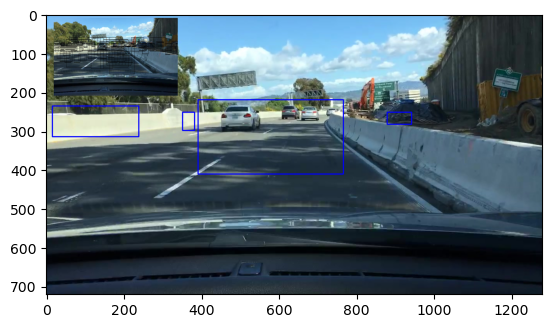

**Found a match**
old centroid= (127, 275)
new centroid= (131, 271)
old bbox= [ 16 236 223  79]
new bbox= [ 12 224 250 318]
**Found a match**
old centroid= (465, 309)
new centroid= (494, 310)
old bbox= [146 210 784 408]
new bbox= [102 106 886 514]
**Found a match**
old centroid= (1035, 247)
new centroid= (1021, 253)
old bbox= [1024  236   23   23]
new bbox= [ 910  214 1132  292]
Appending new object with centroid: (667, 271)
Appending new object with centroid: (279, 259)
**Found a match**
old centroid= (367, 275)
new centroid= (391, 275)
old bbox= [352 252  31  47]
new bbox= [376 252 406 298]
Appending new object with centroid: (1203, 295)
previously detected objects= 0
so far newly detected objects= 10
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 26.22 seconds


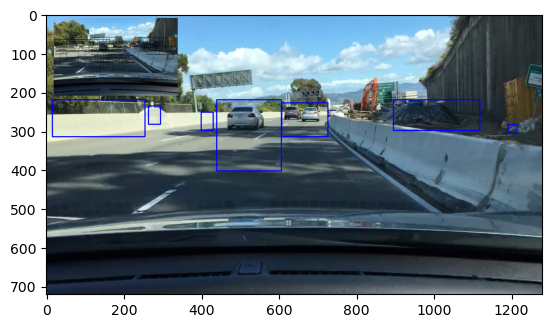

**Found a match**
old centroid= (579, 315)
new centroid= (593, 311)
old bbox= [392 220 375 191]
new bbox= [406 216 780 406]
**Found a match**
old centroid= (1021, 253)
new centroid= (998, 256)
old bbox= [ 910  214 1132  292]
new bbox= [ 432  110 1564  402]
**Found a match**
old centroid= (391, 275)
new centroid= (391, 267)
old bbox= [376 252 406 298]
new bbox= [188 118 594 416]
**Found a match**
old centroid= (131, 271)
new centroid= (123, 277)
old bbox= [ 12 224 250 318]
new bbox= [ -2 118 248 436]
previously detected objects= 0
so far newly detected objects= 10
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 26.27 seconds


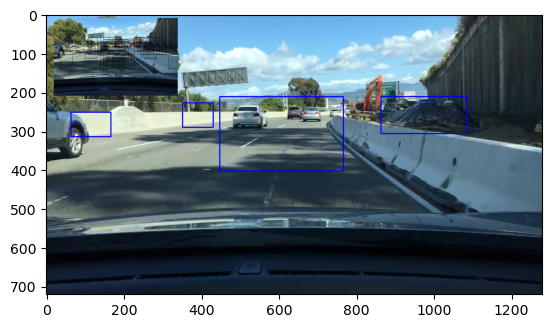

**Found a match**
old centroid= (279, 259)
new centroid= (265, 269)
old bbox= [264 236  31  47]
new bbox= [110 210 420 328]
**Found a match**
old centroid= (593, 311)
new centroid= (608, 311)
old bbox= [406 216 780 406]
new bbox= [218 108 998 514]
Appending new object with centroid: (751, 251)
**Found a match**
old centroid= (998, 256)
new centroid= (1002, 263)
old bbox= [ 432  110 1564  402]
new bbox= [ 220   62 1784  464]
Appending new object with centroid: (27, 279)
previously detected objects= 0
number of times detected object appeared:  2
number of times detected object appeared:  2
number of times detected object appeared:  3
number of times detected object appeared:  1
number of times detected object appeared:  2
number of times detected object appeared:  2
number of times detected object appeared:  2
number of times detected object appeared:  0
number of times detected object appeared:  1
number of times detected object appeared:  0
number of times detected object appeared:  0


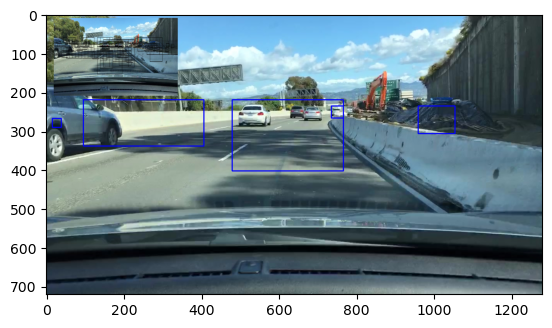

Appending new object with centroid: (407, 311)
Appending new object with centroid: (1055, 267)
previously detected objects= 0
so far newly detected objects= 2
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 25.73 seconds


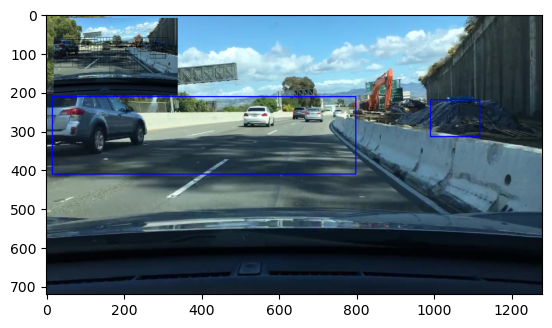

Appending new object with centroid: (175, 287)
Appending new object with centroid: (551, 263)
Appending new object with centroid: (695, 255)
Appending new object with centroid: (1135, 279)
**Found a match**
old centroid= (407, 311)
new centroid= (395, 331)
old bbox= [ 16 212 783 199]
new bbox= [  4 232 786 430]
Appending new object with centroid: (711, 367)
previously detected objects= 0
so far newly detected objects= 7
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 27.40 seconds


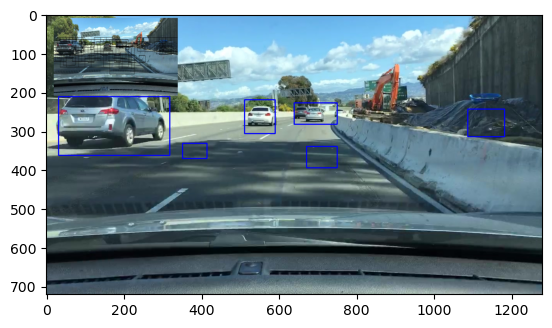

**Found a match**
old centroid= (175, 287)
new centroid= (187, 281)
old bbox= [ 32 212 287 151]
new bbox= [ 36 206 338 356]
**Found a match**
old centroid= (1135, 279)
new centroid= (1157, 275)
old bbox= [1088  244   95   71]
new bbox= [1074  216 1240  334]
Appending new object with centroid: (655, 311)
Appending new object with centroid: (907, 263)
Appending new object with centroid: (343, 379)
previously detected objects= 0
so far newly detected objects= 10
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 25.35 seconds


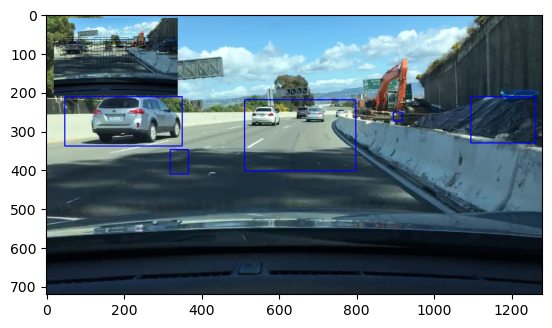

Appending new object with centroid: (279, 275)
Appending new object with centroid: (127, 255)
**Found a match**
old centroid= (551, 263)
new centroid= (561, 263)
old bbox= [512 220  79  87]
new bbox= [522 220 600 306]
**Found a match**
old centroid= (695, 255)
new centroid= (691, 263)
old bbox= [640 228 111  55]
new bbox= [636 228 746 298]
previously detected objects= 0
so far newly detected objects= 12
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 26.57 seconds


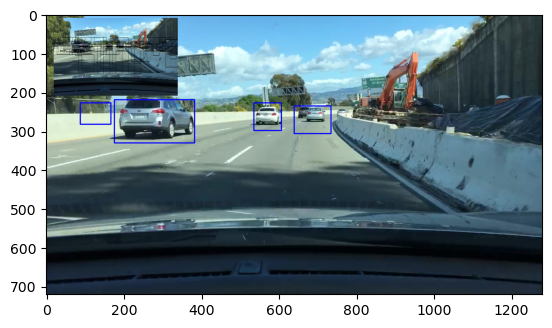

**Found a match**
old centroid= (279, 275)
new centroid= (299, 271)
old bbox= [176 220 207 111]
new bbox= [196 216 402 326]
**Found a match**
old centroid= (187, 281)
new centroid= (191, 262)
old bbox= [ 36 206 338 356]
new bbox= [ 22  84 360 440]
**Found a match**
old centroid= (561, 263)
new centroid= (570, 261)
old bbox= [522 220 600 306]
new bbox= [270 108 870 414]
**Found a match**
old centroid= (691, 263)
new centroid= (689, 257)
old bbox= [636 228 746 298]
new bbox= [ 316  108 1062  406]
**Found a match**
old centroid= (1055, 267)
new centroid= (1047, 267)
old bbox= [992 220 127  95]
new bbox= [ 984  220 1110  314]
**Found a match**
old centroid= (1157, 275)
new centroid= (1140, 263)
old bbox= [1074  216 1240  334]
new bbox= [ 520   96 1760  430]
**Found a match**
old centroid= (1140, 263)
new centroid= (1165, 257)
old bbox= [ 520   96 1760  430]
new bbox= [ 285   42 2045  472]
**Found a match**
old centroid= (907, 263)
new centroid= (911, 267)
old bbox= [896 252  23  23]
new bb

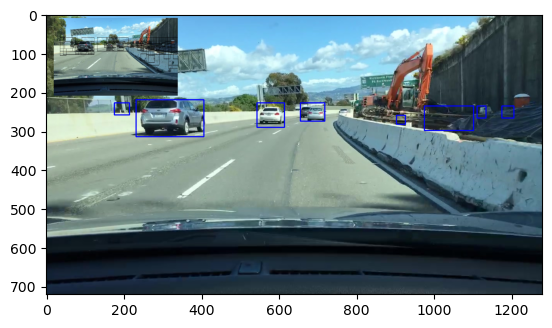

Appending new object with centroid: (155, 243)
Appending new object with centroid: (351, 263)
Appending new object with centroid: (639, 255)
Appending new object with centroid: (811, 243)
Appending new object with centroid: (1027, 275)
Appending new object with centroid: (1147, 279)
previously detected objects= 0
so far newly detected objects= 6
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 26.59 seconds


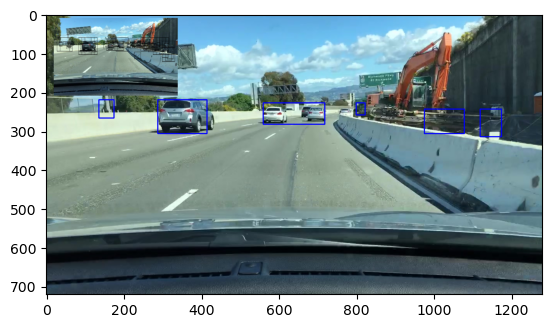

**Found a match**
old centroid= (351, 263)
new centroid= (367, 261)
old bbox= [288 220 127  87]
new bbox= [304 218 430 304]
**Found a match**
old centroid= (1147, 279)
new centroid= (1157, 271)
old bbox= [1120  244   55   71]
new bbox= [1094  228 1220  314]
**Found a match**
old centroid= (639, 255)
new centroid= (617, 255)
old bbox= [560 228 159  55]
new bbox= [538 228 696 282]
**Found a match**
old centroid= (811, 243)
new centroid= (811, 243)
old bbox= [800 228  23  31]
new bbox= [800 228 822 258]
Appending new object with centroid: (695, 259)
**Found a match**
old centroid= (1027, 275)
new centroid= (1047, 273)
old bbox= [976 244 103  63]
new bbox= [ 996  242 1098  304]
previously detected objects= 0
so far newly detected objects= 7
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 25.98 seconds


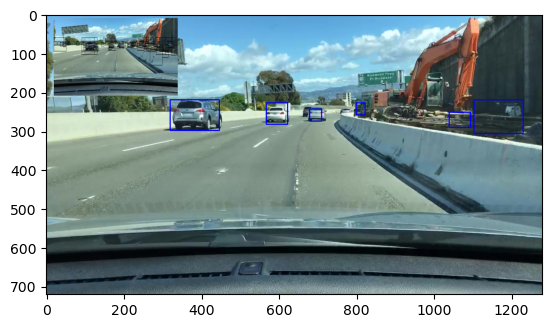

**Found a match**
old centroid= (367, 261)
new centroid= (383, 260)
old bbox= [304 218 430 304]
new bbox= [168 108 598 412]
**Found a match**
old centroid= (617, 255)
new centroid= (608, 255)
old bbox= [538 228 696 282]
new bbox= [260 114 956 396]
Appending new object with centroid: (1239, 263)
**Found a match**
old centroid= (695, 259)
new centroid= (695, 259)
old bbox= [680 244  31  31]
new bbox= [672 236 718 282]
**Found a match**
old centroid= (1047, 273)
new centroid= (1065, 278)
old bbox= [ 996  242 1098  304]
new bbox= [ 516  126 1614  430]
previously detected objects= 0
so far newly detected objects= 8
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 25.93 seconds


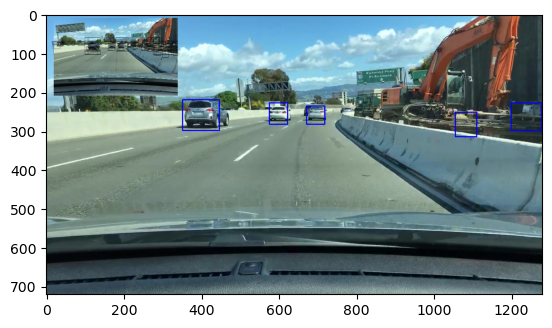

**Found a match**
old centroid= (383, 260)
new centroid= (407, 257)
old bbox= [168 108 598 412]
new bbox= [108  51 706 463]
**Found a match**
old centroid= (811, 243)
new centroid= (821, 243)
old bbox= [800 228 822 258]
new bbox= [ 410  114 1232  372]
**Found a match**
old centroid= (608, 255)
new centroid= (605, 255)
old bbox= [260 114 956 396]
new bbox= [ 127   57 1083  453]
**Found a match**
old centroid= (695, 259)
new centroid= (695, 257)
old bbox= [672 236 718 282]
new bbox= [ 336  116 1054  398]
**Found a match**
old centroid= (1065, 278)
new centroid= (1072, 280)
old bbox= [ 516  126 1614  430]
new bbox= [ 265   65 1879  495]
**Found a match**
old centroid= (1239, 263)
new centroid= (1239, 289)
old bbox= [1200  228   79   71]
new bbox= [1200  254 1278  324]
previously detected objects= 0
so far newly detected objects= 8
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 25.97 seconds


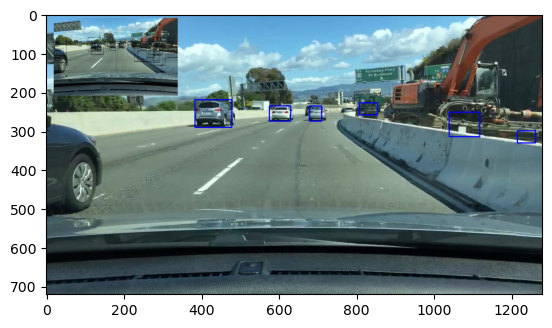

**Found a match**
old centroid= (821, 243)
new centroid= (840, 241)
old bbox= [ 410  114 1232  372]
new bbox= [ 224   55 1456  427]
**Found a match**
old centroid= (155, 243)
new centroid= (141, 261)
old bbox= [136 220  39  47]
new bbox= [ 30 210 252 312]
Appending new object with centroid: (511, 255)
**Found a match**
old centroid= (605, 255)
new centroid= (608, 253)
old bbox= [ 127   57 1083  453]
new bbox= [  67   27 1149  479]
**Found a match**
old centroid= (695, 257)
new centroid= (695, 256)
old bbox= [ 336  116 1054  398]
new bbox= [ 168   57 1222  455]
Appending new object with centroid: (923, 263)
**Found a match**
old centroid= (407, 257)
new centroid= (417, 260)
old bbox= [108  51 706 463]
new bbox= [ 64  29 770 491]
**Found a match**
old centroid= (923, 263)
new centroid= (945, 274)
old bbox= [904 244  39  39]
new bbox= [926 253 964 295]
**Found a match**
old centroid= (1072, 280)
new centroid= (1091, 283)
old bbox= [ 265   65 1879  495]
new bbox= [ 152   36 2030  530]
prev

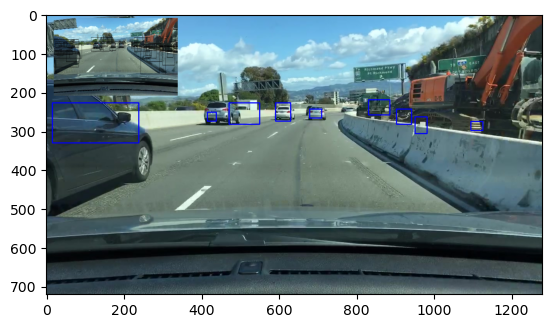

Appending new object with centroid: (871, 251)
Appending new object with centroid: (467, 255)
Appending new object with centroid: (155, 315)
Appending new object with centroid: (619, 251)
Appending new object with centroid: (703, 255)
Appending new object with centroid: (935, 259)
Appending new object with centroid: (1087, 275)
Appending new object with centroid: (307, 283)
Appending new object with centroid: (1183, 327)
**Found a match**
old centroid= (1183, 327)
new centroid= (1175, 345)
old bbox= [1152  316   63   23]
new bbox= [1144  330 1206  360]
previously detected objects= 0
so far newly detected objects= 9
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 25.94 seconds


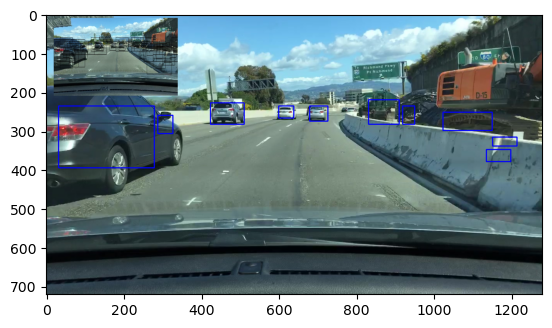

**Found a match**
old centroid= (155, 315)
new centroid= (177, 311)
old bbox= [ 32 236 247 159]
new bbox= [ -6 216 360 406]
**Found a match**
old centroid= (467, 255)
new centroid= (469, 253)
old bbox= [424 228  87  55]
new bbox= [426 222 512 284]
**Found a match**
old centroid= (871, 251)
new centroid= (895, 251)
old bbox= [832 220  79  63]
new bbox= [824 220 966 282]
**Found a match**
old centroid= (703, 255)
new centroid= (699, 255)
old bbox= [680 236  47  39]
new bbox= [676 236 722 274]
**Found a match**
old centroid= (1087, 275)
new centroid= (1111, 281)
old bbox= [1024  252  127   47]
new bbox= [1048  230 1174  332]
**Found a match**
old centroid= (619, 251)
new centroid= (619, 253)
old bbox= [600 236  39  31]
new bbox= [600 238 638 268]
Appending new object with centroid: (1047, 279)
previously detected objects= 0
so far newly detected objects= 10
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)
Time to detect: 26.33 seconds


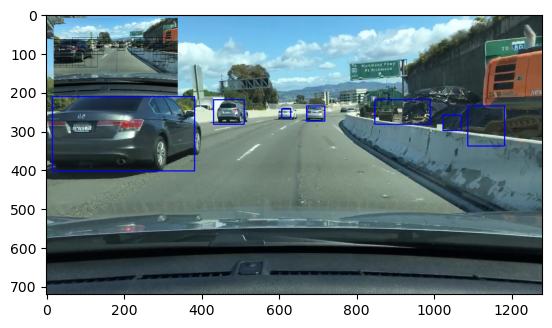

In [7]:
frameMemorizer = FrameMemory(frame_sampling_rate=5,save_frame=False,min_detection_count=8)

#for img in sorted(glob.glob(PATH_TO_FRAMES + 'test/180.jpg')):
for img in sorted(glob.glob(PATH_TO_FRAMES + 'tiny_test/*.jpg')):
#for img in sorted(glob.glob('./test1.jpg')):

    heat_queue = deque(maxlen=HEAT_QUEUE_LENGTH)
    
    allwindows_img, detected_windows_img, heatmap, draw_img, bounding_boxes, time_to_detect  = vehicle_detector.analyse_frame(frame=img,window_search_areas=WINDOW_SEARCH_AREAS,window_sizes=WINDOW_SIZES,overlap=WINDOW_OVERLAP,clf=model, scaler=scaler,proba=PREDICT_PROBA,heat_queue=heat_queue,threshold=HEATMAP_THRESHOLD)
    
    detection_with_memory = frameMemorizer.process_frame(original_img=img,allwindows_img=allwindows_img, detected_windows_img=detected_windows_img,heatmap=heatmap,detected_img=draw_img,bounding_boxes=bounding_boxes)

    print(f"Time to detect: {time_to_detect:.2f} seconds")

    plt.imshow(detection_with_memory)

    plt.show()
    

# Video Processing

- Loop over the entire test_set  and apply the pipeline to detect the vehicles.   
Returns a video with the annotated frames on vehicles detected.


In [10]:
frameSize = (1280,720)
avg_time_to_detect = []

frameMemorizer = FrameMemory(frame_sampling_rate=5,save_frame=False,min_detection_count=8)

out = cv2.VideoWriter('test_output_2.mp4',cv2.VideoWriter_fourcc(*'avc1'), 9, frameSize)

#for filename in glob.glob('./test/*.jpg'):
# Loop through the image frames in the dataset
for i in tqdm(range(1, len(os.listdir('./data/initial/raw/frames/test')))):
    # Check if the frame exists
    if os.path.exists(f'./data/initial/raw/frames/test/{i:0>3}.jpg'):
        
        # Read the image frame
        frame_dir = f'./data/initial/raw/frames/test/{i:0>3}.jpg'
        _, _, _, output_img, _, time_to_detect = vehicle_detector.analyse_frame(frame=frame_dir,window_search_areas=WINDOW_SEARCH_AREAS,window_sizes=WINDOW_SIZES,overlap=WINDOW_OVERLAP,clf=model, scaler=scaler,proba=PREDICT_PROBA,heat_queue=heat_queue,threshold=HEATMAP_THRESHOLD)
        
        detection_with_memory = frameMemorizer.process_frame(original_img=img,allwindows_img=allwindows_img, detected_windows_img=detected_windows_img,heatmap=heatmap,detected_img=draw_img,bounding_boxes=bounding_boxes)

        output_img = cv2.cvtColor(detection_with_memory, cv2.COLOR_RGB2BGR)
        out.write(output_img)
        avg_time_to_detect.append(time_to_detect)

print(f"Average time to detect: {np.mean(avg_time_to_detect):.2f} seconds")
out.release()

  0%|          | 1/201 [00:26<1:27:17, 26.19s/it]

Appending new object with centroid: (443, 129)
Skipping bounding box
Appending new object with centroid: (275, 141)
**Found a match**
old centroid= (275, 141)
new centroid= (295, 139)
old bbox= [472 228  79  55]
new bbox= [256 112 334 166]
Appending new object with centroid: (355, 133)
**Found a match**
old centroid= (443, 129)
new centroid= (457, 135)
old bbox= [832 220  55  39]
new bbox= [430 116 484 154]
Appending new object with centroid: (219, 137)
**Found a match**
old centroid= (457, 135)
new centroid= (474, 144)
old bbox= [430 116 484 154]
new bbox= [232  67 716 221]
Appending new object with centroid: (563, 149)
previously detected objects= 0
so far newly detected objects= 5
img.shape: (720, 1280, 3)
overlay.shape: (200, 320, 3)


  1%|          | 2/201 [00:53<1:28:24, 26.66s/it]

**Found a match**
old centroid= (474, 144)
new centroid= (458, 136)
old bbox= [232  67 716 221]
new bbox= [100  26 816 246]
Skipping bounding box
**Found a match**
old centroid= (295, 139)
new centroid= (285, 140)
old bbox= [256 112 334 166]
new bbox= [118  57 452 223]
**Found a match**
old centroid= (285, 140)
new centroid= (300, 138)
old bbox= [118  57 452 223]
new bbox= [ 74  27 526 249]
**Found a match**
old centroid= (300, 138)
new centroid= (327, 135)
old bbox= [ 74  27 526 249]
new bbox= [ 64  11 590 259]
**Found a match**
old centroid= (458, 136)
new centroid= (464, 138)
old bbox= [100  26 816 246]
new bbox= [ 56  15 872 261]
**Found a match**
old centroid= (219, 137)
new centroid= (219, 137)
old bbox= [416 252  23  23]
new bbox= [208 126 230 148]
**Found a match**
old centroid= (464, 138)
new centroid= (477, 145)
old bbox= [ 56  15 872 261]
new bbox= [ 41  15 913 275]
**Found a match**
old centroid= (563, 149)
new centroid= (563, 149)
old bbox= [1096  276   31   23]
new bbox= 

  1%|▏         | 3/201 [01:23<1:33:49, 28.43s/it]

**Found a match**
old centroid= (477, 145)
new centroid= (460, 137)
old bbox= [ 41  15 913 275]
new bbox= [  4   0 916 274]
Skipping bounding box
**Found a match**
old centroid= (327, 135)
new centroid= (301, 138)
old bbox= [ 64  11 590 259]
new bbox= [  6   9 596 267]
**Found a match**
old centroid= (301, 138)
new centroid= (308, 137)
old bbox= [  6   9 596 267]
new bbox= [ 10   4 606 270]
**Found a match**
old centroid= (308, 137)
new centroid= (331, 135)
old bbox= [ 10   4 606 270]
new bbox= [ 28   0 634 270]
**Found a match**
old centroid= (460, 137)
new centroid= (465, 139)
old bbox= [  4   0 916 274]
new bbox= [  7   2 923 276]
**Found a match**
old centroid= (219, 137)
new centroid= (219, 137)
old bbox= [208 126 230 148]
new bbox= [104  63 334 211]
**Found a match**
old centroid= (465, 139)
new centroid= (478, 146)
old bbox= [  7   2 923 276]
new bbox= [ 17   8 939 284]
**Found a match**
old centroid= (563, 149)
new centroid= (563, 149)
old bbox= [548 138 578 160]
new bbox= [274

  2%|▏         | 4/201 [01:48<1:29:00, 27.11s/it]

**Found a match**
old centroid= (478, 146)
new centroid= (460, 137)
old bbox= [ 17   8 939 284]
new bbox= [ -9  -5 929 279]
Skipping bounding box
**Found a match**
old centroid= (331, 135)
new centroid= (303, 138)
old bbox= [ 28   0 634 270]
new bbox= [-14   3 620 273]
**Found a match**
old centroid= (303, 138)
new centroid= (309, 137)
old bbox= [-14   3 620 273]
new bbox= [ -1   1 619 273]
**Found a match**
old centroid= (309, 137)
new centroid= (332, 135)
old bbox= [ -1   1 619 273]
new bbox= [ 23  -1 641 271]
**Found a match**
old centroid= (460, 137)
new centroid= (465, 139)
old bbox= [ -9  -5 929 279]
new bbox= [  1   0 929 278]
**Found a match**
old centroid= (219, 137)
new centroid= (219, 137)
old bbox= [104  63 334 211]
new bbox= [ 52  32 386 242]
**Found a match**
old centroid= (465, 139)
new centroid= (478, 146)
old bbox= [  1   0 929 278]
new bbox= [ 14   7 942 285]
**Found a match**
old centroid= (563, 149)
new centroid= (563, 149)
old bbox= [274  69 852 229]
new bbox= [137

  2%|▏         | 5/201 [02:12<1:24:40, 25.92s/it]

**Found a match**
old centroid= (478, 146)
new centroid= (460, 137)
old bbox= [ 14   7 942 285]
new bbox= [-11  -5 931 279]
Skipping bounding box
**Found a match**
old centroid= (332, 135)
new centroid= (303, 138)
old bbox= [ 23  -1 641 271]
new bbox= [-17   3 623 273]
**Found a match**
old centroid= (303, 138)
new centroid= (309, 137)
old bbox= [-17   3 623 273]
new bbox= [ -2   1 620 273]
**Found a match**
old centroid= (309, 137)
new centroid= (332, 135)
old bbox= [ -2   1 620 273]
new bbox= [ 22  -1 642 271]
**Found a match**
old centroid= (460, 137)
new centroid= (465, 139)
old bbox= [-11  -5 931 279]
new bbox= [  0   0 930 278]
**Found a match**
old centroid= (219, 137)
new centroid= (219, 137)
old bbox= [ 52  32 386 242]
new bbox= [ 26  16 412 258]
**Found a match**
old centroid= (465, 139)
new centroid= (478, 146)
old bbox= [  0   0 930 278]
new bbox= [ 13   7 943 285]
**Found a match**
old centroid= (563, 149)
new centroid= (563, 149)
old bbox= [137  35 989 263]
new bbox= [  6

  2%|▏         | 5/201 [02:38<1:43:23, 31.65s/it]

**Found a match**
old centroid= (478, 146)
new centroid= (460, 137)
old bbox= [ 13   7 943 285]
new bbox= [-11  -5 931 279]
Skipping bounding box
**Found a match**
old centroid= (332, 135)
new centroid= (303, 138)
old bbox= [ 22  -1 642 271]
new bbox= [-18   3 624 273]
**Found a match**
old centroid= (303, 138)
new centroid= (309, 137)
old bbox= [-18   3 624 273]
new bbox= [ -3   1 621 273]
**Found a match**
old centroid= (309, 137)
new centroid= (332, 135)
old bbox= [ -3   1 621 273]
new bbox= [ 22  -1 642 271]
**Found a match**
old centroid= (460, 137)
new centroid= (465, 139)
old bbox= [-11  -5 931 279]
new bbox= [  0   0 930 278]
**Found a match**
old centroid= (219, 137)
new centroid= (219, 137)
old bbox= [ 26  16 412 258]
new bbox= [ 13   8 425 266]
**Found a match**
old centroid= (465, 139)
new centroid= (478, 146)
old bbox= [  0   0 930 278]
new bbox= [ 13   7 943 285]
**Found a match**
old centroid= (563, 149)
new centroid= (563, 149)
old bbox= [  69   18 1057  280]
new bbox= 

IndexError: invalid index to scalar variable.

In [14]:
from IPython.display import HTML

HTML("""
    <video alt="test" controls>
        <source src="test_output_2.mp4" type="video/mp4">
    </video>
""")

# Creating a Kaggle submission file

Suppose we have a set of bounding boxes of format `x, y, width, height`:

In [19]:
rows = []
avg_time_to_detect = []

for img_path in tqdm(sorted(glob.glob(PATH_TO_FRAMES + 'test/*.jpg'))):
#for img in sorted(glob.glob(PATH_TO_FRAMES + 'test/001.jpg')):
#for img in sorted(glob.glob('./test1.jpg')):

    heat_queue = deque(maxlen=HEAT_QUEUE_LENGTH)
    
    _, _, _, _, bounding_boxes, time_to_detect = vehicle_detector.analyse_frame(frame=img_path,window_search_areas=WINDOW_SEARCH_AREAS,window_sizes=WINDOW_SIZES,overlap=WINDOW_OVERLAP,clf=model, scaler=scaler,proba=PREDICT_PROBA,heat_queue=heat_queue,threshold=HEATMAP_THRESHOLD)
    avg_time_to_detect.append(time_to_detect)
    rle = run_length_encoding(bounding_boxes_to_mask(bounding_boxes, H, W))
    
    # Take only the filename
    img_path = img_path.split('/')[-1]
    rows.append(['test/' + img_path, rle])

print(f"Average time to detect: {np.mean(avg_time_to_detect):.2f} seconds")

100%|██████████| 202/202 [1:23:42<00:00, 24.87s/it]

Average time to detect: 24.77 seconds


For simplicity, let's say they are the same for all test images (yours won't be). Then, we can create a Kaggle submission file like this:

In [20]:
df_prediction = pd.DataFrame(columns=['Id', 'Predicted'], data=rows).set_index('Id')
df_prediction.head()

Predicted
Id                                                             
test/001.jpg  271488 639 272768 639 274048 639 275328 639 27...
test/002.jpg  271528 631 272808 631 274088 631 275368 631 27...
test/003.jpg  281992 375 283272 375 284552 375 285832 375 28...
test/004.jpg  281616 239 282040 167 282496 223 282896 239 28...
test/005.jpg  271808 319 272224 223 273088 319 273504 223 27...

In [21]:
df_prediction.to_csv('sample_submission_1.csv')

# Compute Dice Score (train frames)

Compute the Dice Score on the training set to check accuracy:

In [22]:
def dice_score(pred,ground_thruth,k=1):
    intersection = np.sum(pred[ground_thruth==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(ground_thruth))
    return dice

In [23]:
def get_bounding_boxes(df_annotation, path_to_frame):
    """
    Returns the ground truth bounding boxes for a given frame in the dataset.
    """
    assert path_to_frame in df_annotation['frame_id'].values
    bounding_boxes = df_annotation[df_annotation['frame_id'] == path_to_frame].bounding_boxes.values[0]
    return bounding_boxes

In [28]:
avg_dice_score = []

for img_path in tqdm(sorted(glob.glob(PATH_TO_FRAMES + 'train/A_199.jpg'))):
    # ============== Get PREDS for the current image ============== #
    heat_queue = deque(maxlen=HEAT_QUEUE_LENGTH)
    
    _, _, _, _, pred_bounding_boxes, time_to_detect  = vehicle_detector.analyse_frame(frame=img_path,window_search_areas=WINDOW_SEARCH_AREAS,window_sizes=WINDOW_SIZES,overlap=WINDOW_OVERLAP,clf=model, scaler=scaler,proba=PREDICT_PROBA,heat_queue=heat_queue,threshold=HEATMAP_THRESHOLD)
    
    print(f"Time to detect: {time_to_detect:.2f} seconds")

    # ============== Get GROUND TRUTH for the current image ============== #
    ground_truth_bounding_boxes = get_bounding_boxes(df_ground_truth, img_path)

    # ============== Convert the bounding boxes to masks ============== #
    pred_mask = bounding_boxes_to_mask(pred_bounding_boxes, H, W)
    ground_truth_mask = bounding_boxes_to_mask(ground_truth_bounding_boxes, H, W)

    # ============== Compute the DICE score ============== #
    dice = dice_score(pred_mask,ground_truth_mask, 1)
    print(f'Dice Score :{dice}')
    avg_dice_score.append(dice)

100%|██████████| 1/1 [00:25<00:00, 25.15s/it]

Time to detect: 25.05 seconds
Dice Score :0.6978741349895528


In [28]:
np.mean(avg_dice_score)

0.5078644036450721